In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/content/sample_data/train.csv")

# Create binary toxic label
df["label"] = (df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].sum(axis=1) > 0).astype(int)

df = df[["comment_text","label"]]
df.head()

,comment_text,label
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df.info()
df.describe(include='all')
print("\n")

df.isnull().sum()
df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  159571 non-null  object
 1   label         159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB




,count
label,
0,143346
1,16225


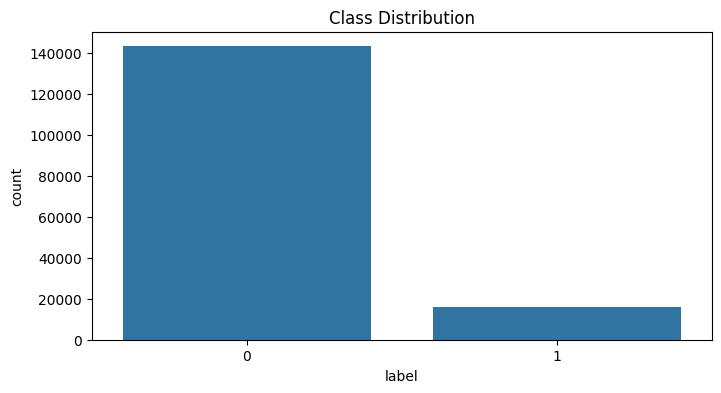

In [5]:
plt.figure(figsize=(8,4))
sns.countplot(x=df['label'])
plt.title("Class Distribution")
plt.show()

In [6]:
df["text_length"] = df["comment_text"].apply(len)
df["num_words"]  = df["comment_text"].apply(lambda x: len(x.split()))

In [7]:
df[['comment_text','text_length','num_words']].head()

,comment_text,text_length,num_words
0,Explanation\nWhy the edits made under my usern...,264,43
1,D'aww! He matches this background colour I'm s...,112,17
2,"Hey man, I'm really not trying to edit war. It...",233,42
3,"""\nMore\nI can't make any real suggestions on ...",622,113
4,"You, sir, are my hero. Any chance you remember...",67,13


In [8]:
df[['text_length','num_words']].describe()

,text_length,num_words
count,159571.000000,159571.000000
mean,394.073221,67.273527
std,590.720282,99.230702
min,6.000000,1.000000
25%,96.000000,17.000000
50%,205.000000,36.000000
75%,435.000000,75.000000
max,5000.000000,1411.000000


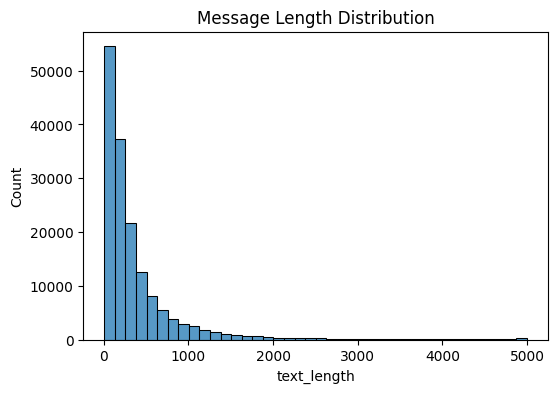

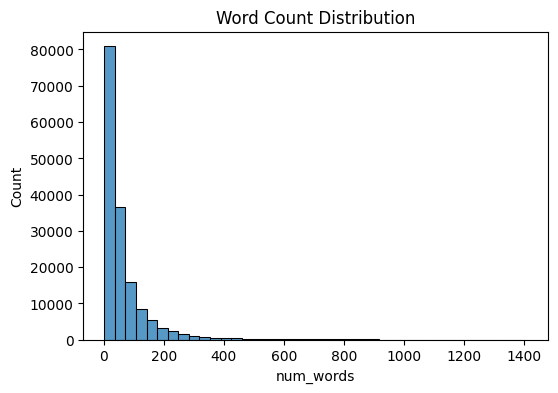

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=40)
plt.title("Message Length Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['num_words'], bins=40)
plt.title("Word Count Distribution")
plt.show()

In [14]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

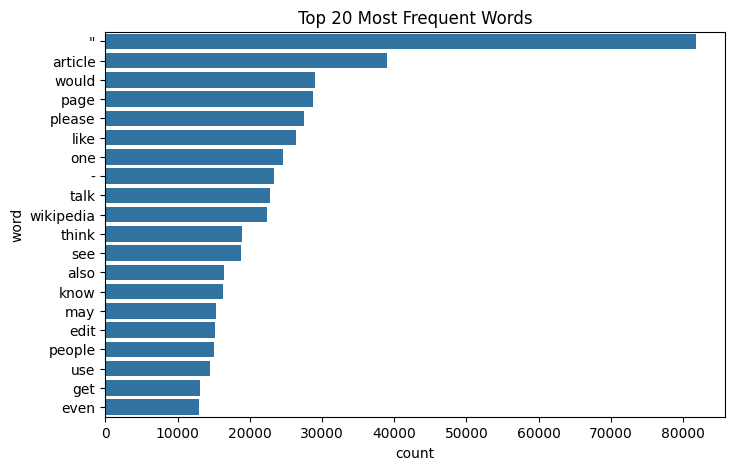

In [15]:
from collections import Counter
stop = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([w for w in text.lower().split() if w not in stop])

df["clean_text"] = df["comment_text"].apply(remove_stopwords)

words = " ".join(df["clean_text"]).split()
word_freq = Counter(words).most_common(20)

freq_df = pd.DataFrame(word_freq, columns=['word','count'])

plt.figure(figsize=(8,5))
sns.barplot(x='count', y='word', data=freq_df)
plt.title("Top 20 Most Frequent Words")
plt.show()

Preprocess text

In [16]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z ]","",text)
    text = " ".join([w for w in text.split() if w not in stop])
    return text

df["clean_text"] = df["comment_text"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Convert to tf-idf

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["clean_text"]
y = df["label"]

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)


LogisticRegression()

Accuracy: 0.9548174839417202
Precision: 0.917516218721038
Recall: 0.6103575832305795
F1 Score: 0.7330618289522399

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28671
           1       0.92      0.61      0.73      3244

    accuracy                           0.95     31915
   macro avg       0.94      0.80      0.85     31915
weighted avg       0.95      0.95      0.95     31915



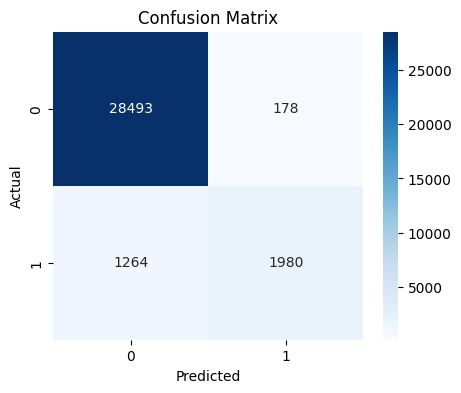

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predictions
y_pred = model.predict(X_test)

# core metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# detailed report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
import pickle

pickle.dump(model, open("toxic_model.pkl","wb"))
pickle.dump(vectorizer, open("tfidf.pkl","wb"))

In [21]:
def check(text):
    x = vectorizer.transform([text])
    pred = model.predict(x)[0]
    label = "Toxic" if pred == 1 else "Non-Toxic"
    print(f"Input: {text}")
    print(f"Prediction: {label}\n")


In [22]:
print("---- Unexpected Inputs ----")
check("I love this place!")                     # positive tone
check("asdfghjk what is this???")              # nonsense
check("FREE MONEY!!! CLICK NOW")               # spam-like
check("What are you even talking about")       # neutral


---- Unexpected Inputs ----
Input: I love this place!
Prediction: Non-Toxic

Input: asdfghjk what is this???
Prediction: Non-Toxic

Input: FREE MONEY!!! CLICK NOW
Prediction: Non-Toxic

Input: What are you even talking about
Prediction: Non-Toxic



In [23]:
print("---- Real Comments ----")
check("You are so annoying, stop talking")
check("Thank you for the help, appreciate it!")
check("This article is completely useless")
check("Nice work! Keep improving.")


---- Real Comments ----
Input: You are so annoying, stop talking
Prediction: Non-Toxic

Input: Thank you for the help, appreciate it!
Prediction: Non-Toxic

Input: This article is completely useless
Prediction: Non-Toxic

Input: Nice work! Keep improving.
Prediction: Non-Toxic



In [24]:
print("---- Slight Modifications ----")
check("You are stupid")
check("You are stupid!!!")             # added intensity
check("You are not stupid")            # negation
check("You are a little stupid")       # softened tone


---- Slight Modifications ----
Input: You are stupid
Prediction: Toxic

Input: You are stupid!!!
Prediction: Toxic

Input: You are not stupid
Prediction: Toxic

Input: You are a little stupid
Prediction: Toxic



In [25]:
print("---- Slang & Emojis ----")
check("lol chill bro 😂")
check("This is trash")
check("This is kinda bad ngl")


---- Slang & Emojis ----
Input: lol chill bro 😂
Prediction: Non-Toxic

Input: This is trash
Prediction: Toxic

Input: This is kinda bad ngl
Prediction: Non-Toxic



In [26]:
print("---- Noisy Text ----")
check("You are stup1d!!!")
check("Y0u are s0 dumb")
check("!!!!!!!")
check("....")


---- Noisy Text ----
Input: You are stup1d!!!
Prediction: Non-Toxic

Input: Y0u are s0 dumb
Prediction: Toxic

Input: !!!!!!!
Prediction: Non-Toxic

Input: ....
Prediction: Non-Toxic

